In [1]:
import os
import multiprocessing as mp
from functools import partial
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import sys
import matplotlib.pyplot as plt
sys.path.append('./SMICE_code/src')
from util_SMICE import *
import matplotlib.lines as mlines
from itertools import combinations
def calTMscores_pair(args):
    """Worker function to process a single pair of elements"""
    i, j, high_freq_elements, fsr_seq_extend, seqs = args
    
    TMscore_fsr = compute_fsr_tmscore(high_freq_elements[i], high_freq_elements[j], fsr_seq_extend)
    TMscore_whole = compute_fsr_tmscore(high_freq_elements[i], high_freq_elements[j], seqs[0])
    
    return i, j, TMscore_fsr, TMscore_whole

2025-12-04 12:04:49.259856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 12:04:49.303311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 12:04:49.321664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 12:04:49.321688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 12:04:49.333267: I tensorflow/core/platform/cpu_feature_gua

In [2]:
def extract_cluster_res(option):
    cluster_size_threshold = 3
    n_plddt = 3 # number of top plddt values
    num_clusters = []
    clusters_sizes = []
    jobnames_valid = []
    plDDT_by_cluster_list = []
    TMscores_list = []
    TMscores_fsr_list = []
    fsr_seq_extend_len = []
    MSA_sizes = []
    Seqs_len = []
    ensembles_PCAdim = []
    if option == "FS":
        with open('./SMICE_code/config/config_SMICE_benchmark.json', 'r') as f:
            config = json.load(f)
        jobnames = config["jobnames"]
    else:
        if option == "pdb":
            with open('./SMICE_common/config/config_SMICE_benchmark.json', 'r') as f:
                config = json.load(f)
            jobnames = config["jobnames"]+config["jobnames_long"]
        elif option == "atlas":
            with open('./SMICE_atlas/config/config_SMICE_benchmark.json', 'r') as f:
                config = json.load(f)
            jobnames = config["jobnames"]
        elif option == "codnas":
            with open('./SMICE_codnas/config/config_SMICE_benchmark.json', 'r') as f:
                config = json.load(f)
            jobnames = config["jobnames"]
        else:
            return None
    MSA_saved_basedir = config["MSA_saved_basedir"]
    base_output_dir = config["base_output_dir"]
    coreset_folder = "cluster_greedy_fast"
    coreset_indice = 'cluster_file'
    coreset_data = 'cluster.json.zip'
    output_SMICE_file = "outputs_SMICE.json.zip"
    output_SMICE_enhanced_file = "outputs_enhanced.json.zip"
    jobnames_valid = []
    for jobname in jobnames:
        coreset_dir = f"{base_output_dir}{jobname}/{coreset_folder}"
        if os.path.exists(f"{coreset_dir}/{coreset_data}"):
            if option != "FS":
                if os.path.exists(f"{base_output_dir}{jobname}/{output_SMICE_enhanced_file}"):
                    output_SMICE_enhanced = pd.read_json(f"{base_output_dir}{jobname}/{output_SMICE_enhanced_file}")
                    if output_SMICE_enhanced.shape[0]==0:
                        continue
                else:
                    continue
            output_SMICE = pd.read_json(f"{base_output_dir}{jobname}/{output_SMICE_file}")
            cluster_data = pd.read_json(f"{coreset_dir}/{coreset_data}")
            cluster_res_df = pd.read_table(f"{coreset_dir}/res_cluster.tsv")
            value_counts = cluster_res_df[coreset_indice].value_counts()
            high_freq_counts = value_counts[value_counts > cluster_size_threshold].tolist()
            high_freq_elements = value_counts[value_counts > cluster_size_threshold].index.tolist()
            ## compute fsr tmscore
            MSA_saved_dir = f"{MSA_saved_basedir}{jobname}/"
            IDs,seqs = load_fasta(os.path.join(MSA_saved_dir, "msa.a3m"))
            fsr_identify_res = np.load(f"{base_output_dir}{jobname}/pred_fsr.npy")
            start_res,end_res = extend_interval_symmetric(fsr_identify_res[0], fsr_identify_res[1], 1, len(seqs[0]))
            fsr_seq_extend = seqs[0][int(start_res):int(end_res)]
            if os.path.exists(f"{coreset_dir}/TMscores_fsr_pairwise.npy") and os.path.exists(f"{coreset_dir}/TMscores_pairwise.npy"):
                TMscores_fsr = np.load(f"{coreset_dir}/TMscores_fsr_pairwise.npy")
                TMscores = np.load(f"{coreset_dir}/TMscores_pairwise.npy")
            else:
                TMscores_fsr = np.ones((len(high_freq_elements), len(high_freq_elements)))
                TMscores = np.ones((len(high_freq_elements), len(high_freq_elements)))
                # Prepare all pairs to process (only lower triangle, i > j)
                pairs = []
                for i in range(len(high_freq_elements)):
                    for j in range(i):
                        pairs.append((i, j, high_freq_elements, fsr_seq_extend, seqs))
                # Use multiprocessing
                num_processes = mp.cpu_count()  # Use all available cores
                with mp.Pool(processes=num_processes) as pool:
                    results = pool.map(calTMscores_pair, pairs)
                # Update the result arrays
                for i, j, TMscore_fsr, TMscore_whole in results:
                    TMscores_fsr[i, j] = TMscore_fsr
                    TMscores_fsr[j, i] = TMscore_fsr
                    TMscores[i, j] = TMscore_whole
                    TMscores[j, i] = TMscore_whole
                np.save(f"{coreset_dir}/TMscores_fsr_pairwise.npy",TMscores_fsr)
                np.save(f"{coreset_dir}/TMscores_pairwise.npy",TMscores)
            if TMscores_fsr.shape[0]>1:
                TMscores_fsr_list.append(TMscores_fsr)
                TMscores_list.append(TMscores)
                if len(high_freq_counts)>0:
                    cluster_info = pd.merge(output_SMICE, cluster_res_df,  left_on="pdb_path", right_on='file')
                    high_freq_coresets = value_counts[value_counts > cluster_size_threshold].keys().tolist()
                    cluster_info = cluster_info[cluster_info[coreset_indice].isin(high_freq_coresets)]
                    plDDT_by_cluster = np.sort(cluster_info.groupby(coreset_indice)['avg_plddt'].max().tolist())[-n_plddt:]#np.max(cluster_info.groupby(coreset_indice)['avg_plddt'].max().tolist())
                    top_plDDT_idx = np.argsort(cluster_info.groupby(coreset_indice)['avg_plddt'].max().tolist())[-n_plddt:]
                    if len(plDDT_by_cluster) < n_plddt:
                        plDDT_by_cluster = np.concatenate(( np.array([np.nan]*(n_plddt-len(plDDT_by_cluster))) ,plDDT_by_cluster))
                    num_clusters.append(len(high_freq_counts))
                    clusters_sizes.append(high_freq_counts)
                    jobnames_valid.append(jobname)
                    plDDT_by_cluster_list.append(plDDT_by_cluster)
                    fsr_seq_extend_len.append(len(fsr_identify_res)/len(seqs[0]))
                    MSA_sizes.append(len(seqs))
                    Seqs_len.append(len(seqs[0]))
    return(num_clusters,clusters_sizes,plDDT_by_cluster_list,jobnames_valid,TMscores_fsr_list,TMscores_list,fsr_seq_extend_len,Seqs_len,MSA_sizes)

In [3]:
dataframes = []
for dataset in ["FS","atlas","codnas","pdb"]:
    num_clusters,clusters_sizes,plDDT_by_cluster_list,jobs,TMscores_fsr_list,TMscores_list,fsr_seq_extend_len,seq_len,MSA_size = extract_cluster_res(dataset)
    # TM-score DataFrame
    minTM_fsr = [np.min(TM) for TM in TMscores_fsr_list]
    avgTM_fsr = [np.mean(TM) for TM in TMscores_fsr_list]
    q25TM_fsr = [np.quantile(TM,0.25) for TM in TMscores_fsr_list]
    q50TM_fsr = [np.quantile(TM,0.50) for TM in TMscores_fsr_list]
    q75TM_fsr = [np.quantile(TM,0.75) for TM in TMscores_fsr_list]
    df = pd.DataFrame({
        "jobname": jobs,
        "min-pairwise-TMscores": minTM_fsr,
        "avg-pairwise-TMscores": avgTM_fsr,
        "number of clusters": num_clusters,
        "cluster decay rate 1":[sizes[1] / sizes[0] if len(sizes) >2 and sizes[0]>0 else 0 for sizes in clusters_sizes ],
        "cluster decay rate 2":[sizes[2] / sizes[1] if len(sizes) >2 and sizes[1]>0 else 0 for sizes in clusters_sizes ],
        "cluster decay rate 3":[sizes[3] / sizes[2] if len(sizes) >3 and sizes[2]>0 else 0 for sizes in clusters_sizes ],
    })
    cols = [f'Top {i+1} pLDDT' for i in range(3)]
    df[cols] = np.array(plDDT_by_cluster_list)[:,::-1]
    df["dataset"] = dataset  # label (target)
    dataframes.append(df)
# === 4. Combine all into one master DataFrame ===
df_all = pd.concat(dataframes, ignore_index=True)

In [4]:
df_all.to_csv("~/Yongkai/Alphafold2/code_CoID/Metamorphic_classify.csv")

## feature comparison

In [5]:
cols_select = ["jobname", "number of clusters", "cluster decay rate 1", "min-pairwise-TMscores","avg-pairwise-TMscores","Top 1 pLDDT", "dataset"]
df_draw = df_all[cols_select]
feature_names = cols_select[1:-1]

/tmp/ipykernel_623169/2900249215.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1["dataset"] = "metamorphic"
/tmp/ipykernel_623169/2900249215.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="dataset", y=feature, data=df_full,
/tmp/ipykernel_623169/2900249215.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="dataset", y=feature, data=df_full,
/tmp/ipykernel_623169/2900249215.py:30: FutureWarning: 

Passing `palette` without ass

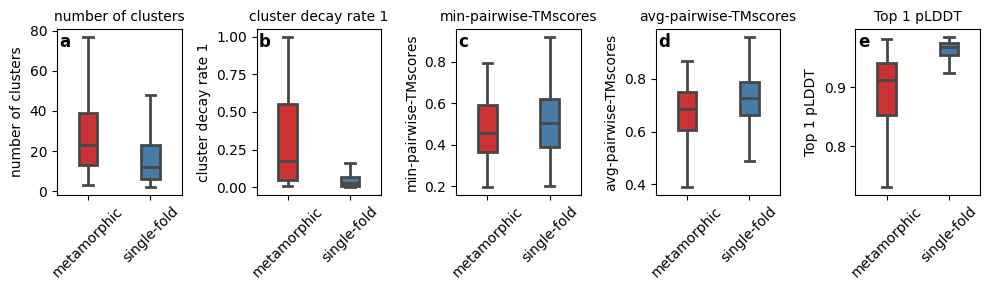

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the data into two groups
group1 = df_draw[df_draw['dataset'] == 'FS']  # Replace with your actual group names
group2 = pd.concat([df_draw[df_draw['dataset'] == 'atlas'],df_draw[df_draw['dataset'] == 'codnas']])   # Replace with your actual group names

group1["dataset"] = "metamorphic"
group2["dataset"] = "single-fold"
df_full = pd.concat([group1,group2])


# Perform Mann-Whitney U test for each feature
for feature in feature_names:
    # Extract data for this feature
    data1 = group1[feature].dropna()
    data2 = group2[feature].dropna()
    

n_plots = len(feature_names)
fig, axes = plt.subplots(1, n_plots, figsize=(10, 3))
axes = axes.ravel()

for i in range(n_plots):
    feature = feature_names[i]
    sns.boxplot(x="dataset", y=feature, data=df_full, 
               width=0.3, palette='Set1', showfliers=False, ax=axes[i],
               linewidth=2)
    axes[i].set_title(f'{feature}',fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')

# Apply to all subplots before your specific plotting
labels = [f'{(chr(97 + i))}' for i in range(n_plots+1)]

for i, ax in enumerate(axes):
    ax.text(0.02, 0.98, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')

plt.tight_layout()
plt.show()

